# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm # for progress bar
from sklearn.metrics import confusion_matrix

# check which version of tensorflow is on here
print("tf.__version__",tf.__version__)


tf.__version__ 2.15.0


In [2]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [3]:
# import the urllib library
import urllib.request
 
# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

#Open the local h5 file with h5py
df=h5py.File('neutrino1.h5','r')

In [4]:
#Print the keys in the neutrino meta data
print(df.keys())
print(df['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df['cvnmap']))
print(df['neutrino']['evt'])
event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(7001, 16000)
<HDF5 dataset "evt": shape (7001, 1), type "<u4">


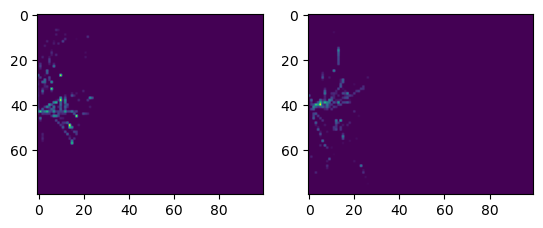

In [5]:
#Plot the first event, look it is a nice long muon track
fig, ax = plt.subplots(1,2)
ax[0].imshow(event0[1].T)
ax[1].imshow(event0[0].T)

In [6]:
print("Neutrino Final State code",df['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df['neutrino']['interaction'][3]))
print("Neutrino energy",df['neutrino']['nuenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV


(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.        ,  8.22953796, 16.45907593, 24.68861389, 32.91815186,
        41.14768982, 49.37722778, 57.60676575, 65.83630371, 74.06584167,
        82.29537964]),
 <BarContainer object of 10 artists>)

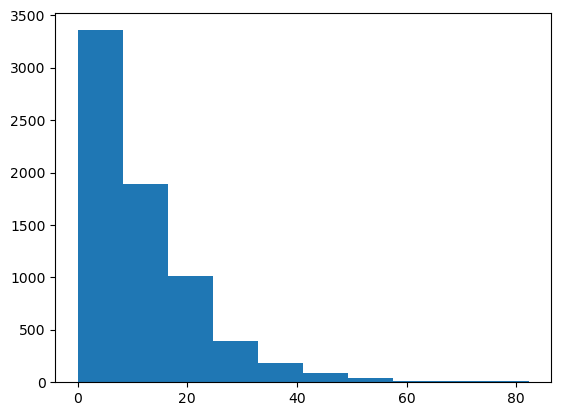

In [7]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy)

We first define some key functions that will be used later in the code.

In [33]:
# Define functions required for data processing.

def split_data(data,train_size,valid_size):
  """
  This function splits given images data it into training, validation and testing data.
  The data is split into training and validation according to their specified proportions.
  The remainder of the data is allocated to testing.

  Args:
    data: A numpy array of at least 2 dimensions where the first dimension is the number of data samples.
    train_size: float between 0-1 representing proportion of image data to allocate for training.
    valid_size: float between 0-1 representing proportion of image data to allocate for validation.

  Returns:
    Train: Training data
    Valid: Validation data
    Test: Testing data
    """
  # Find numbers of data samples for training and validation.
  trn = int(data.shape[0]*train_size)
  vld = int(data.shape[0]*valid_size)

  # Split dataset
  Train = data[:trn]
  Valid = data[trn:trn+vld]
  Test = data[trn+vld:] # To ensure that Train + Valid + Test = total number of data samples.

  return Train,Valid,Test

def get_class_weights(train_labels):
    """
    This function calculates the class weights based off the class distribution in the training data.

    Args:
      train_labels: Binary labels of the training samples - 1D numpy array.

    Returns:
      class_weights: A Python dictionary which maps the class labels (0,1) to their corresponding weights (weight_0,weight_1).

    """
    # Find numbers of positive and negative samples
    total_samples = len(train_labels)
    num_1 = np.sum(train_labels == 1)
    num_0 = np.sum(train_labels == 0)

    # Set weights
    weight_0 = total_samples / (2 * num_0)
    weight_1 = total_samples / (2 * num_1)
    class_weights = {0: weight_0, 1: weight_1}

    return class_weights


def CNN_Model(input_shape):
  """
  This function defines the layers for the CNN unit which is later called on to build the classifier.
  There are 7 layers, Input > Convolutional 1 > Dropout 1 > Max Pooling 1 > Convolutional 2 > Dropout 2 > Max Pooling 2.
  Args:
    input_shape: The input shape for the CNN unit.
  
  Returns:
    Model: CNN model.

  """

  input_layer = keras.Input(shape=input_shape) # Input
  conv1 = keras.layers.Conv2D(16, (3, 3),padding='same',activation='relu')(input_layer) # Convolutional Layer 1
  Drop1 = keras.layers.Dropout(0.25)(conv1) # Dropout Layer 1
  maxpool1 = keras.layers.MaxPooling2D((2,2),padding='same')(Drop1) # Max Pooling Layer 1
  conv2 = keras.layers.Conv2D(32, (3, 3),padding='same',activation='relu')(maxpool1) # Convolutional Layer 2
  Drop2 = keras.layers.Dropout(0.25)(conv2) # Dropout Layer 2
  maxpool2 = keras.layers.MaxPooling2D((2,2),padding='same')(Drop2) # Max Pooling Layer 2
  #flatten = keras.layers.Flatten()(maxpool2)

  return keras.Model(inputs=input_layer, outputs=maxpool2)


def Build_Classifier():
  """
  This function splits each pair of images into two separate image inputs with dimensions 100x80x1.
  The function then defines the two-input classifier architecture. The classifier is built but not compiled.

  Args:
    None
  Return:
    Classifier: The two-input classifier model.
    
  """

  input_shape = (100,80,1)

  # Call CNN model for images A
  inputA = keras.Input(shape=input_shape)
  outputA = CNN_Model(input_shape)(inputA)

  # Call CNN model for images B
  inputB = keras.Input(shape=input_shape)
  outputB = CNN_Model(input_shape)(inputB)

  # Concatenate the outputs of both CNN models
  merged = keras.layers.concatenate([outputA, outputB],axis=1)

  # Layers for the combined input
  conv = keras.layers.Conv2D(32,(5,5),padding='same',activation='relu',input_shape=input_shape)(merged) # Convolutional
  Drop = keras.layers.Dropout(0.25)(conv) # Dropout
  maxpool = keras.layers.MaxPooling2D((2,2),padding='same')(Drop) # Maxpool
  Flatten = keras.layers.Flatten()(maxpool) # Flatten
  Dense = keras.layers.Dense(200, activation='relu')(Flatten) # Dense
  output_layer = keras.layers.Dense(1, activation='sigmoid')(Dense) # Output

  # Final model
  Classifier = keras.Model(inputs=[inputA, inputB], outputs=output_layer)

  return Classifier




def energy_test2(test_energy,test_images,test_labels,num_batches,model,optimal_threshold):
  """
  This function splits the test_images into equal batches corresponding to different energy ranges.
  Then the trained model makes predictions on each batch and the overall accuracy is recorded against the mean energy of each batch.
   
  Args:
    test_energy: Array of energies (nu/lep) corresponding to test dataset
    test_images: Array of test images, dimensions num_samples x 2 x 100 x 80 x num_channels
    test_labels: Array of labels corresponding to test_images
    num_batches: Number of batches to test the model on and the number of bins for the histogram
    model: Trained two-input classifier.
    optimal threshold: Threshold at which overall accuracy is maximised.
      
  Returns:
    mean_energies: List of mean energies of the batches.
    pos_acc: List of the model's positive class accuracy when tested on each energy batch.
    neg_acc: List of the model's negative class accuracy when tested on each energy batch.
      
  """
  # Sort energy, images, and label into order of ascending energy
  sorted_indices = np.argsort(test_energy.flatten()) # Must take 1D array input to work
  sorted_en = test_energy[sorted_indices]
  sorted_images = test_images[sorted_indices]
  sorted_labels = test_labels[sorted_indices]
    
  # Split the ordered images, labels, and energies into batches - this is a list of array views
  batch_images = np.array_split(sorted_images,num_batches,axis=0)
  batch_labels = np.array_split(sorted_labels,num_batches,axis=0) 
  batch_en = np.array_split(sorted_en,num_batches,axis=0)

  # Initialise mean energies and metrics
  pos_acc = []
  neg_acc = []
  mean_energies = []

  # Loop through list of batches
  for i in range(num_batches):
    image_in = batch_images[i] # pick batch input images
    label_in = batch_labels[i] # pick batch input labels
    energy_bin = batch_en[i] # pick batch associated energies
        
    # Find mean energy of the batch
    mean_en = np.mean(energy_bin)
    mean_energies.append(mean_en)

    # Split batch images into two inputs for the model and add channel dimension
    image_inA = np.expand_dims(image_in[:,0,:,:],axis=-1)
    image_inB = np.expand_dims(image_in[:,1,:,:],axis=-1)

    # Make Predictions
    pred_prob = model.predict([image_inA,image_inB])

    # Define binary labels with optimal threshold
    binary_labels = (pred_prob > optimal_threshold).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_in, binary_labels).ravel()

    # Calculate class accuracies
    pos_accuracy = tp/(tp + fn)
    neg_accuracy = tn/(tn + fp)
    
    # Append accuracies
    pos_acc.append(pos_accuracy)
    neg_acc.append(neg_accuracy)
    
  return mean_energies,pos_acc,neg_acc




We will not be able to achieve high enough model performance by training on the  ∼  7000 data samples within each file. We therefore require data from multiple files. We have an issue with RAM if we try to store all the files in memory at once and add them into one training dataset. Instead we will read the files in one at a time in a loop.

In [9]:
import numpy as np
import urllib.request
import h5py

# Define number of files we want to use
num_files = 4

# Initialize empty lists for image and metadata arrays
images_list = []
interaction_list = []
nuenergy_list = []
lepenergy_list = []
f_state_list = []
data_files = []

for i in range(1, num_files + 1):  # Cannot start at 0 (file 0 doesn't exist)
    
    # url of the file
    url = f'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino{i}.h5'

    # file name with a unique identifier
    local_name = f'neutrino{i}_{np.random.randint(10000)}.h5'

    try:
        # Retrieve file
        urllib.request.urlretrieve(url, local_name)

        # Open and read in the file
        file_obj = h5py.File(local_name, 'r')

        # Append file object to the list
        data_files.append(file_obj)

        # Process data and append to lists

        images_list.append(np.array(file_obj['cvnmap']))
        interaction_list.append(np.array(file_obj['neutrino']['interaction']))
        nuenergy_list.append(np.array(file_obj['neutrino']['nuenergy']))
        lepenergy_list.append(np.array(file_obj['neutrino']['lepenergy']))
        f_state_list.append(np.array(file_obj['neutrino']['finalstate']))
    except Exception as e:
        print(f"Error processing file {i}: {e}")

    finally:
        # Close the file after reading
        if 'file_obj' in locals():
            file_obj.close()



# Concatenate the arrays - this is our data
image_data = np.concatenate(images_list, axis=0)
images = image_data.reshape(image_data.shape[0],2,100,80)/np.max(image_data) # Normalise
interaction = np.concatenate(interaction_list, axis=0)
nuenergy = np.concatenate(nuenergy_list, axis=0)
lepenergy = np.concatenate(lepenergy_list, axis=0)
f_state = np.concatenate(f_state_list, axis=0)

print(images.shape)
print(interaction.shape)
print(nuenergy.shape)
print(lepenergy.shape)
print(f_state.shape)

(27985, 2, 100, 80)
(27985, 1)
(27985, 1)
(27985, 1)
(27985, 1)


We now need to create the binary label for the interactions. All interactions 0-3 inclusive are $\nu_{\mu}$ CC type. Hence if the interaction < 4, its label = 1 which is positive. Otherwise, its label = 0 which is negative. We can also check to see what the imbalance in our dataset looks like. Once the labels are obtained, we can split our data into training, validation, and testing. I will choose 60% training, 20% validation and 20% testing. 

In [10]:
# for muon neutrino CC label = 1, else label = 0
labels = np.zeros_like(interaction)
labels[interaction < 4] = 1

# Check how much of the data is positive result 1 and negative result 0
num_positives = np.sum(labels == 1)
num_negatives = np.sum(labels == 0)
total_num = labels.shape[0]
pos = (num_positives/total_num)*100
neg = (num_negatives/total_num)*100
print('Percentage of data in the positive class =',pos,'%')
print('Percentage of data in the negative class =',neg,'%')


# Split all data - 80% training, 10% validation, 10% testing.
train_images, valid_images, test_images = split_data(images,0.8,0.1)
train_labels, valid_labels, test_labels = split_data(labels,0.8,0.1)
train_nuen, valid_nuen, test_nuen = split_data(nuenergy,0.8,0.1)
train_lepen, valid_lepen, test_lepen = split_data(lepenergy,0.8,0.1)
train_fs, valid_fs, test_fs = split_data(f_state,0.8,0.1)


Percentage of data in the positive class = 88.24012864034304 %
Percentage of data in the negative class = 11.759871359656959 %


Now that the data is obtained, labelled, and split for training - we can build the Classifier and train it. This classifier takes the 'top view' and 'side view' images as inputs from two separate branches. Hence we have to split the data. Once initialised, we compile the model with our chosen optimizer, loss function, and metrics. We then calculate class_weights, and then train the models. We choosean an appropriate number of steps per epoch to balance model performance with training time.

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100, 80, 1)]         0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 100, 80, 1)]         0         []                            
                                                                                                  
 model_6 (Functional)        (None, 25, 20, 32)           4800      ['input_9[0][0]']             
                                                                                                  
 model_7 (Functional)        (None, 25, 20, 32)           4800      ['input_11[0][0]']            
                                                                                            

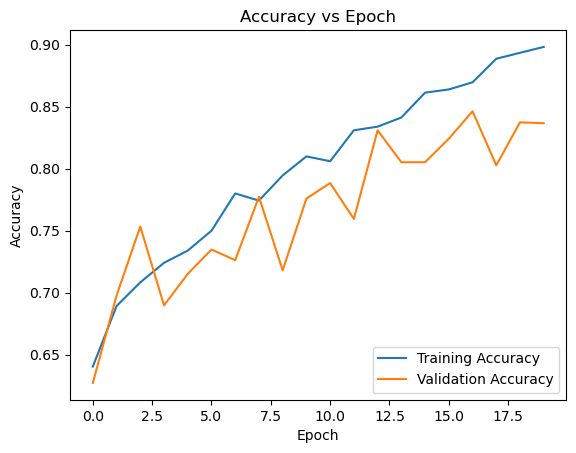

In [27]:
# Segment data into the two images
train_imagesA = train_images[:,0,:,:]
train_imagesB = train_images[:,1,:,:]
valid_imagesA = valid_images[:,0,:,:]
valid_imagesB = valid_images[:,1,:,:]

# Reshape to include channel dimension
train_in_A = np.expand_dims(train_imagesA,axis=-1)
train_in_B = np.expand_dims(train_imagesB,axis=-1)
valid_in_A = np.expand_dims(valid_imagesA,axis=-1)
valid_in_B = np.expand_dims(valid_imagesB,axis=-1)

model = Build_Classifier()

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','Precision','Recall'])

model.summary()


# Find the class weights
class_weights = get_class_weights(train_labels=train_labels)


num_samples = train_images.shape[0]
batch_size = 30
#steps = num_samples // batch_size # Find appropriate number of steps per epoch
steps = 450 # Need to up this - or REMOVE - it is calculated automatically



# Train the model
history=model.fit([train_in_A, train_in_B], train_labels, batch_size=32, epochs=20,
                  validation_data=([valid_in_A,valid_in_B],valid_labels),
                  class_weight=class_weights,
                  steps_per_epoch=steps)


# Plot accuracy against epochs

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

To avoid having to run the training again, we can plot the training history in a separate code cell. We are interested in looking at the Precision and Recall. We have 1635,633 paramaters in total for this model - according to the model summary.

88/88 [==============================] - 1s 15ms/step - loss: 0.4172 - accuracy: 0.8349 - precision: 0.9490 - recall: 0.8590
Test Loss: 0.41724225878715515
Test Accuracy: 0.834941029548645
Test Precision: 0.9489704370498657
Test Recall: 0.8589951395988464
steps per epoch = 450


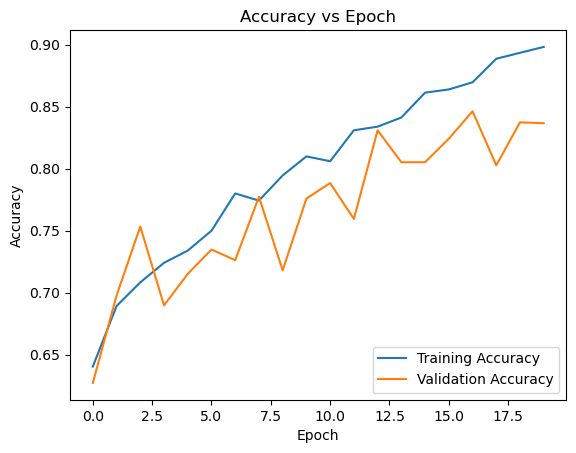

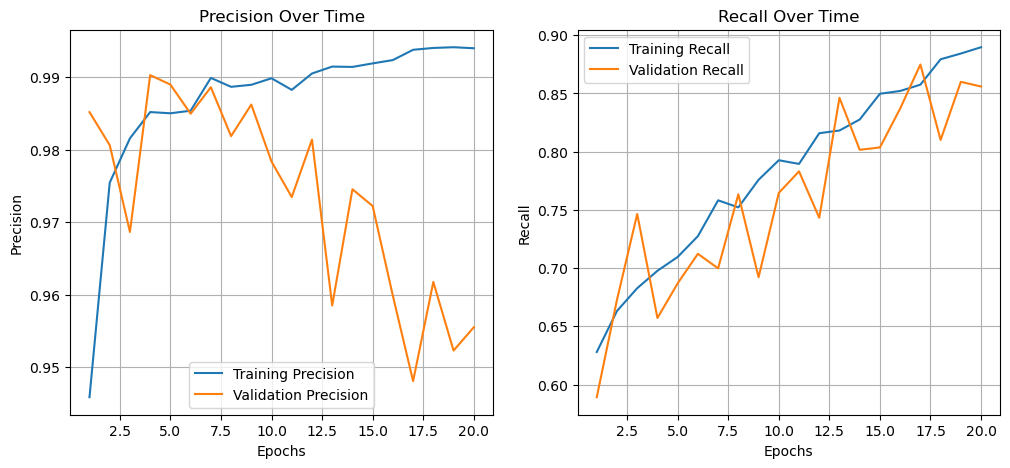

In [28]:
# Split the test images for the two-inputs - and reshape for channel dimension
test_imagesA = np.expand_dims(test_images[:,0,:,:],axis=-1)
test_imagesB = np.expand_dims(test_images[:,1,:,:],axis=-1)

# Test Model
[loss,accuracy,precision,recall] = model.evaluate([test_imagesA,test_imagesB], test_labels)


print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Accuracy_Training.png')

print('steps per epoch =', steps)

# Extract Precision and Recall from the training history
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Obtain epochs for plotting
epochs = range(1, len(precision) + 1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Precision
ax1.plot(epochs, precision, label='Training Precision')
ax1.plot(epochs,val_precision,label='Validation Precision')
ax1.set_title('Precision Over Time')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid(True)

# Plot Recall
ax2.plot(epochs, recall, label='Training Recall')
ax2.plot(epochs, val_recall, label='Validation Recall')
ax2.set_title('Recall Over Time')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Recall')
ax2.legend()
ax2.grid(True)

plt.savefig('Train_1_PR.png')

We are also interested in how the metrics of the confusion matrix perform. Training the model on too many metrics at once may increase training time unecessarily or cause errors. Hence, we train the same model again, this time looking at the $TP$, $TN$, $FP$, and $FN$ metrics. 

In [29]:
# Initialise model
model2 = Build_Classifier()

# Find the class weights
class_weights = get_class_weights(train_labels=train_labels)

# Compile optimizer, loss, and metrics
model2.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','TruePositives','TrueNegatives','FalsePositives','FalseNegatives'])

# Train the model - same parameters as before
history2=model2.fit([train_in_A, train_in_B], train_labels, batch_size=32, epochs=20,
                  validation_data=([valid_in_A,valid_in_B],valid_labels),
                  class_weight=class_weights,
                  steps_per_epoch=450)

Epoch 1/20
450/450 [==============================] - 53s 114ms/step - loss: 0.5788 - accuracy: 0.6272 - true_positives: 7722.0000 - true_negatives: 1310.0000 - false_positives: 372.0000 - false_negatives: 4996.0000 - val_loss: 0.3922 - val_accuracy: 0.8181 - val_true_positives: 2148.0000 - val_true_negatives: 141.0000 - val_false_positives: 172.0000 - val_false_negatives: 337.0000
Epoch 2/20
450/450 [==============================] - 57s 127ms/step - loss: 0.4745 - accuracy: 0.7114 - true_positives: 8762.0000 - true_negatives: 1474.0000 - false_positives: 241.0000 - false_negatives: 3911.0000 - val_loss: 0.3801 - val_accuracy: 0.7888 - val_true_positives: 1989.0000 - val_true_negatives: 218.0000 - val_false_positives: 95.0000 - val_false_negatives: 496.0000
Epoch 3/20
450/450 [==============================] - 71s 157ms/step - loss: 0.4297 - accuracy: 0.7269 - true_positives: 8915.0000 - true_negatives: 1552.0000 - false_positives: 158.0000 - false_negatives: 3775.0000 - val_loss: 0.3

Again here we use a separate cell for plots to avoid running the code for training again.

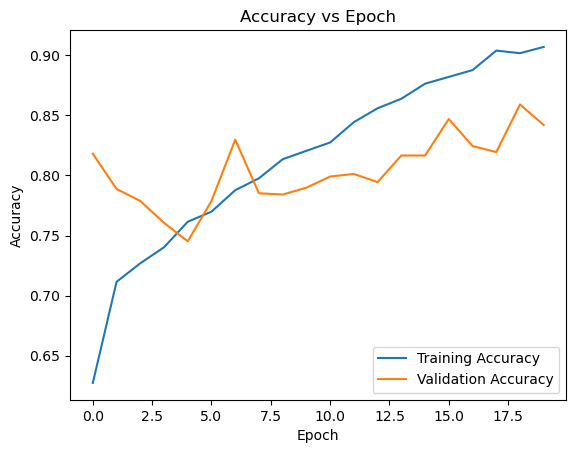

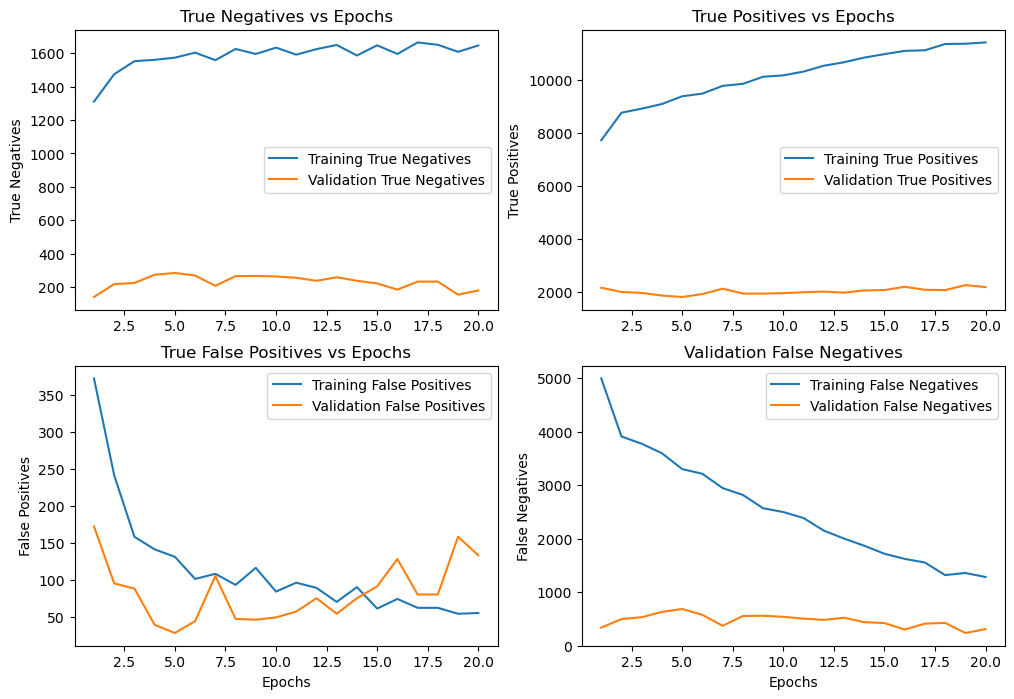

In [31]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Extract metrics from history2 and find epochs
TN = history2.history['true_negatives']
TP = history2.history['true_positives']
FP = history2.history['false_positives']
FN = history2.history['false_negatives']

TN_val = history2.history['val_true_negatives']
TP_val = history2.history['val_true_positives']
FP_val = history2.history['val_false_positives']
FN_val = history2.history['val_false_negatives']
epochs = range(1, len(TN) + 1)


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# Plot TN, TP, FP, and FN over epochs for both training and validation data
axs[0, 0].plot(epochs, TN, label='Training True Negatives')
axs[0, 0].plot(epochs, TN_val, label='Validation True Negatives')
axs[0, 0].set_title('True Negatives vs Epochs')
#axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('True Negatives')
axs[0, 0].legend()

axs[0, 1].plot(epochs, TP, label='Training True Positives')
axs[0, 1].plot(epochs, TP_val, label='Validation True Positives')
axs[0, 1].set_title('True Positives vs Epochs')
#axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('True Positives')
axs[0, 1].legend()

axs[1, 0].plot(epochs, FP, label='Training False Positives')
axs[1, 0].plot(epochs, FP_val, label='Validation False Positives')
axs[1, 0].set_title('True False Positives vs Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('False Positives')
axs[1, 0].legend()

axs[1, 1].plot(epochs, FN, label='Training False Negatives')
axs[1, 1].plot(epochs, FN_val, label='Validation False Negatives')
axs[1, 1].set_title('Validation False Negatives')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('False Negatives')
axs[1, 1].legend()

plt.savefig('Quad_Metrics_Training.png')


We want to find the accuracy of the model using the predictions in the confusion matrix. We find accuracy by:

$$\text{Majority Class Accuracy/Precision} = \frac{TP}{TP + FN}$$
$$\text{Minority Class Accuracy} = \frac{TN}{TN + FP}$$

We want to plot the Positive Class Accuracy against the Negative Class Accuracy for a range of thresholds and identify the optimal threshold at which both are relatively high. Critically, we want to see whether adjusting the threshold improves the Minority Negative Class accuracy.

We begin by computing the confusion matrix and calculating the Class accuracies. We do this in a loop and plot the both accuracies against each other. The point at which both are maximised (in balance with each other), is the optimum threshold.

88/88 [==============================] - 3s 31ms/step
Maximum Accuracy: 0.8098959735980061
Optimal Threshold: 0.86
0.7678282009724473 0.851963746223565


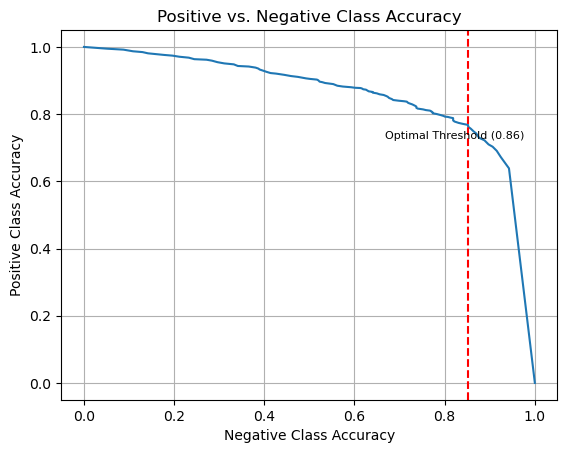

In [54]:
from sklearn.metrics import confusion_matrix



# Make predictions with the model
pred_prob =model.predict([test_imagesA,test_imagesB]) # Using testing images from above cells

# Initialize lists to store class accuracies
pos_accuracies = []
neg_accuracies = []

# Define a range of thresholds
threshold_range = np.linspace(0, 1, 101)


# Loop through thresholds
for threshold in threshold_range:

    # Make predictions using the current threshold
    binary_labels = (pred_prob > threshold).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, binary_labels).ravel()

    # Calculate class accuracies
    pos_accuracy = tp/(tp + fn)
    neg_accuracy = tn/(tn + fp) # This should be 1 - pos_acc

    # Append accuracies to lists
    pos_accuracies.append(pos_accuracy)
    neg_accuracies.append(neg_accuracy)


# Convert lists to arrays to calculate overall accuracy
pos_acc,neg_acc = np.array(pos_accuracies),np.array(neg_accuracies)

# Find mean accuracy
mean_acc = (pos_acc + neg_acc)/2

# Find maximum accuracy
Max_acc = np.max(mean_acc)
print('Maximum Accuracy:',Max_acc)

# Find threshold corresponding to maximum accuracy
# Find threshold corresponding to maximum accuracy
optimal_threshold_index = np.argmax(mean_acc)
optimal_threshold = threshold_range[optimal_threshold_index]
print('Optimal Threshold:', optimal_threshold)

# Get precision and negative accuracy values at optimal threshold
optimum_pos = pos_acc[optimal_threshold_index]
optimum_neg = neg_acc[optimal_threshold_index]

print(optimum_pos,optimum_neg)


# Plot positive class accuracy against negative class accuracy
plt.plot(neg_accuracies, pos_accuracies)
plt.xlabel('Negative Class Accuracy')
plt.ylabel('Positive Class Accuracy')
plt.title('Positive vs. Negative Class Accuracy')
plt.grid(True)

# Plot vertical line at optimal threshold
plt.axvline(neg_acc[optimal_threshold_index], color='r', linestyle='--', label='Optimal Threshold')

# Annotate the optimal threshold point
plt.annotate(f'Optimal Threshold ({optimal_threshold:.2f})', 
             (neg_acc[optimal_threshold_index], pos_acc[optimal_threshold_index]), 
             textcoords="offset points", xytext=(-10,-10), ha='center', fontsize=8)

#plt.show()
plt.savefig('Optimal Threshold.png')


With the optimal theshold identified, we can now plot the confusion matrix on the old default threshold 0.5, and the new optimal threshold, and compare. 

0.86
88/88 [==============================] - 2s 17ms/step


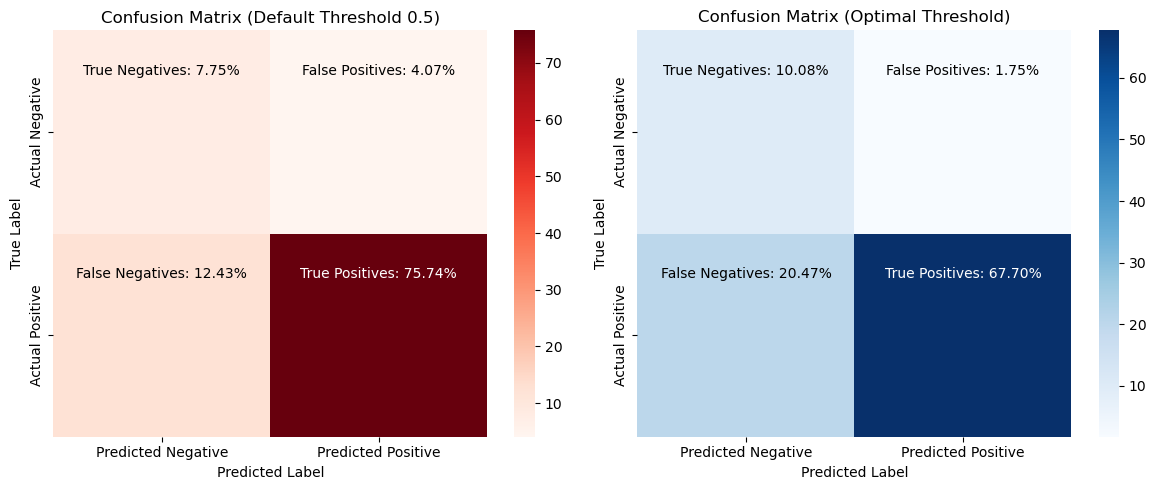

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Define the threshold values
thresh_default = 0.5
thresh_optimal = optimal_threshold
print(thresh_optimal)

# Make predictions with the model
predictions = model.predict([test_imagesA, test_imagesB]) # Using testing images from above cells

# Threshold the predictions to obtain binary predictions for both thresholds
binary_labels_default = binary_labels = (pred_prob > thresh_default).astype(int)
binary_labels_optimal = binary_labels = (pred_prob > thresh_optimal).astype(int)

# Compute confusion matrix for the default threshold
tn_default, fp_default, fn_default, tp_default = confusion_matrix(test_labels, binary_labels_default).ravel()
conf_matrix_default = np.array([[tn_default, fp_default], [fn_default, tp_default]])

# Compute confusion matrix for the optimal threshold
tn_optimal, fp_optimal, fn_optimal, tp_optimal = confusion_matrix(test_labels, binary_labels_optimal).ravel()
conf_matrix_optimal = np.array([[tn_optimal, fp_optimal], [fn_optimal, tp_optimal]])

# Plot both confusion matrices side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Calculate percentages for default threshold
conf_matrix_percent_default = conf_matrix_default / np.sum(conf_matrix_default) * 100

# Calculate percentages for optimal threshold
conf_matrix_percent_optimal = conf_matrix_optimal / np.sum(conf_matrix_optimal) * 100

# Plot confusion matrix for default threshold with percentages
sns.heatmap(conf_matrix_percent_default, fmt='.2f', cmap='Reds',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=axs[0])
axs[0].set_title('Confusion Matrix (Default Threshold 0.5)')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

# Plot confusion matrix for optimal threshold with percentages
sns.heatmap(conf_matrix_percent_optimal, fmt='.2f', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=axs[1])
axs[1].set_title('Confusion Matrix (Optimal Threshold)')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')

# Add annotations for False Positives and False Negatives for default threshold
axs[0].text(1.5, 0.2, f'False Positives: {conf_matrix_percent_default[0, 1]:.2f}%', ha='center', va='center', color='black')
axs[0].text(0.5, 0.2, f'True Negatives: {conf_matrix_percent_default[0, 0]:.2f}%', ha='center', va='center', color='black')
axs[0].text(1.5, 1.2, f'True Positives: {conf_matrix_percent_default[1, 1]:.2f}%', ha='center', va='center', color='white')
axs[0].text(0.5, 1.2, f'False Negatives: {conf_matrix_percent_default[1, 0]:.2f}%', ha='center', va='center', color='black')

# Add annotations for False Positives and False Negatives for optimal threshold
axs[1].text(1.5, 0.2, f'False Positives: {conf_matrix_percent_optimal[0, 1]:.2f}%', ha='center', va='center', color='black')
axs[1].text(0.5, 0.2, f'True Negatives: {conf_matrix_percent_optimal[0, 0]:.2f}%', ha='center', va='center', color='black')
axs[1].text(1.5, 1.2, f'True Positives: {conf_matrix_percent_optimal[1, 1]:.2f}%', ha='center', va='center', color='white')
axs[1].text(0.5, 1.2, f'False Negatives: {conf_matrix_percent_optimal[1, 0]:.2f}%', ha='center', va='center', color='black')

plt.tight_layout()
#plt.show()
plt.savefig('Confusion Matrices.png')



Task 2.

We call the energy testing function to test the model's performance on data batches in different energy ranges.
We are interested in comparing the precision/positive class accuracy with the negative class accuracy.



0.84
2/2 [==============================] - 0s 16ms/step
maximum neutrino energy in test data: 74.239044
minimum neutrino energy in test data: 0.0


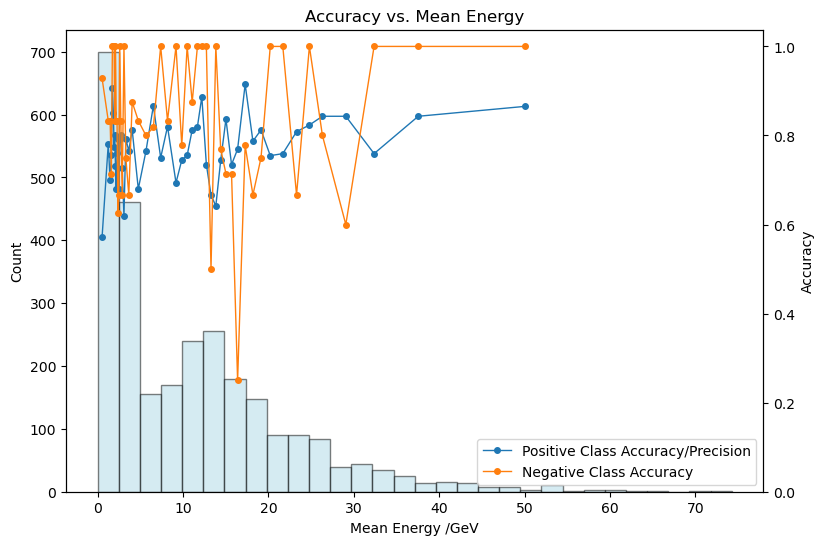

In [37]:

optimal_threshold = 0.84


# Check optimal threshold is correct
print(optimal_threshold)

mean_energies, pos_acc, neg_acc = energy_test2(test_nuen,test_images,test_labels,num_batches=50,model=model,optimal_threshold=optimal_threshold)

print('maximum neutrino energy in test data:',np.max(test_nuen))
print('minimum neutrino energy in test data:',np.min(test_nuen))

# Compute the histogram
hist, bins = np.histogram(test_nuen, bins=30)

# Plot both graphs on the same figure with different y-axes
plt.figure(figsize=(9, 6))

# Create a second y-axis for the histogram
plt.hist(test_nuen, bins=bins, edgecolor='black', color='lightblue', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Mean Energy /GeV')

# Plot accuracy vs. mean energy
plt.twinx()
plt.plot(mean_energies,pos_acc, marker='o',linestyle='-', linewidth=1, markersize=4,label='Positive Class Accuracy/Precision')
plt.plot(mean_energies,neg_acc, marker='o',linestyle='-', linewidth=1, markersize=4,label='Negative Class Accuracy')
plt.xlabel('Mean Energy /GeV')
plt.ylabel('Accuracy')
plt.ylim(0,)
plt.title('Accuracy vs. Mean Energy')
plt.legend(loc='lower right')
#plt.show()
plt.savefig('Nuen PN.png')

Now for lepton energy.

0.84
2/2 [==============================] - 0s 16ms/step
maximum lepton energy in test data: 56.977833
minimum lepton energy in test data: 0.0
[0.10656493, 0.33015564, 0.46226695, 0.5833842, 0.6709648, 0.76130134, 0.85562885, 0.9470874, 1.0208269, 1.1010321, 1.1893098, 1.283695, 1.3663698, 1.4614067, 1.5476252, 1.6254913, 1.7026192, 1.8004, 1.9019552, 2.0208259, 2.1717741, 2.3338966, 2.5666618, 2.8378165, 3.1924317, 3.6341171, 3.9565167, 4.4118695, 4.835022, 5.220046, 5.6702247, 6.1615834, 6.699685, 7.157786, 7.653272, 8.224679, 8.860297, 9.47267, 10.070989, 10.699338, 11.455222, 12.230881, 13.195088, 14.362593, 15.804011, 17.147402, 18.92984, 21.210009, 25.070465, 37.411297]


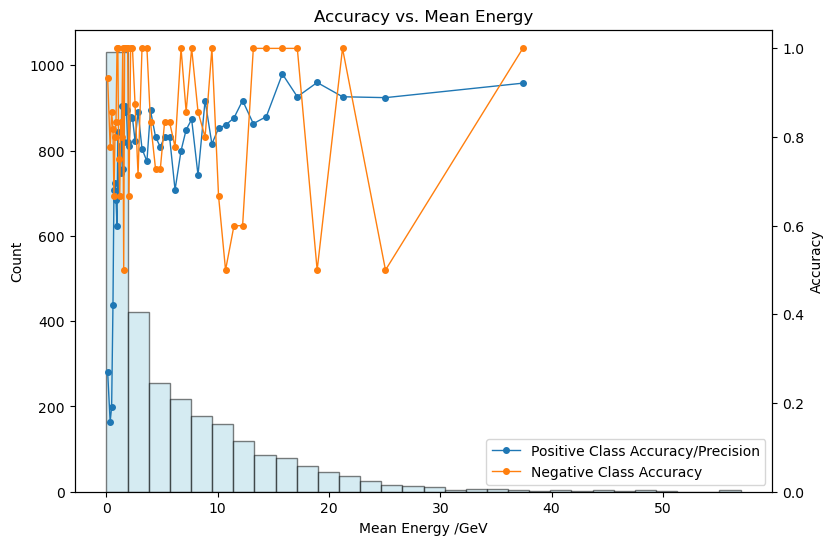

In [38]:

# Check optimal threshold is correct
print(optimal_threshold)

mean_energies, pos_acc, neg_acc = energy_test2(test_lepen,test_images,test_labels,num_batches=50,model=model,optimal_threshold=optimal_threshold)

print('maximum lepton energy in test data:',np.max(test_lepen))
print('minimum lepton energy in test data:',np.min(test_lepen))

# Compute the histogram
hist, bins = np.histogram(test_lepen, bins=30)

# Plot both graphs on the same figure with different y-axes
plt.figure(figsize=(9, 6))

# Create a second y-axis for the histogram
plt.hist(test_lepen, bins=bins, edgecolor='black', color='lightblue', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Mean Energy /GeV')

# Plot accuracy vs. mean energy
plt.twinx()
plt.plot(mean_energies,pos_acc, marker='o',linestyle='-', linewidth=1, markersize=4,label='Positive Class Accuracy/Precision')
plt.plot(mean_energies,neg_acc, marker='o',linestyle='-', linewidth=1, markersize=4,label='Negative Class Accuracy')
plt.xlabel('Mean Energy /GeV')
plt.ylabel('Accuracy')
plt.ylim(0,)
plt.title('Accuracy vs. Mean Energy')
plt.legend(loc='lower right')
#plt.show()
plt.savefig('Lepen PN.png')


print(mean_energies)

We can see that all metrics improve for high energy as indicated by the accuracy, precision, and recall increasing with higher energies, and loss decreasing with higher energies. To understand what might be happening here, it is useful to visualise muon tracks in that high energy bracket and compare it to muon tracks in a lower energy bracket. 

Samples in batch: 55
Samples in batch: 56
Energy of high energy event: [45.6332]
Energy of low energy event: [0.31578547]
20.130487
56.977833


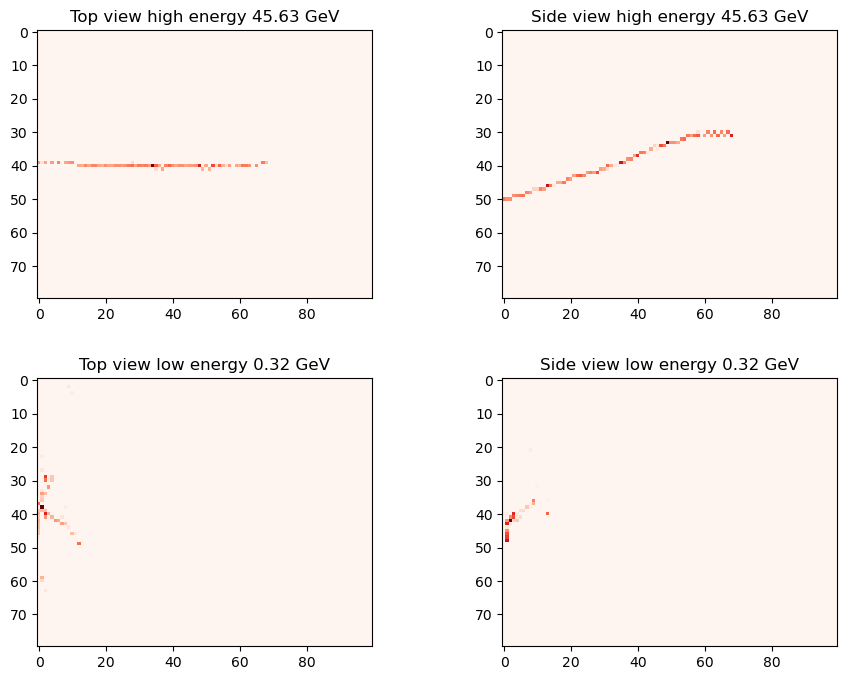

In [39]:

# Sort energy, images, and label into order of ascending energy
sorted_indices = np.argsort(test_lepen.flatten()) # Must take 1D array input to work
sorted_en = test_lepen[sorted_indices]
sorted_images = test_images[sorted_indices]


num_batches = 50 # This is the number of batches we tested the model on for the energies. 
    
# Split the ordered images, labels, and energies into batches - this is a list of array views
batch_images = np.array_split(sorted_images,num_batches,axis=0) 
batch_en = np.array_split(sorted_en,num_batches,axis=0)


# We want to get images from the high energy batch
images_high_en = batch_images[-1]
# We want images from low energy batch to compare
images_low_en = batch_images[1]

print('Samples in batch:',images_high_en.shape[0])
print('Samples in batch:',images_low_en.shape[0])

# Get the corresponding energies
high_energies = batch_en[-1]
low_energies = batch_en[1]

# Pick one image from the high energy batch and low energy batch
image_high_en = images_high_en[48]
image_low_en = images_low_en[22]

# Pick the corresponding energies
high_en = high_energies[45]
low_en = low_energies[22]


print('Energy of high energy event:',high_en)
print('Energy of low energy event:',low_en)



# Plot the top view image in the first subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# High energy
axs[0, 0].imshow(image_high_en[0, :, :].T,cmap='Reds')
axs[0, 0].set_title('Top view high energy 45.63 GeV')
# Plot the side image in the second subplot
axs[0, 1].imshow(image_high_en[1, :, :].T,cmap='Reds')
axs[0, 1].set_title('Side view high energy 45.63 GeV')

# Low energy
axs[1, 0].imshow(image_low_en[0, :, :].T,cmap='Reds')
axs[1, 0].set_title('Top view low energy 0.32 GeV')
# Plot the side image in the second subplot
axs[1, 1].imshow(image_low_en[1, :, :].T,cmap='Reds')
axs[1, 1].set_title('Side view low energy 0.32 GeV')

# Adjust spacing between subplots to remove white space
plt.subplots_adjust(wspace=0, hspace=0.3)

# Display the plot
plt.savefig('HighLow_en.png')

print(np.min(batch_en[-3]))
print(np.max(batch_en[-1]))

Interaction Type

We are interested in determining the classifier's dependence on the interaction type. We can see that the interactions largely fall into the categories of CC QE, CC RES, CC DIS, CC Other, and NC/Other types of interaction. We want to see how the classifier performs depending on the interaction type.

To do this, we must first categorise the interactions into these types to create separate batches of testing data, similar to investigated the model's dependence on the neutrino and lepton energy.

We see that original class labels 0,4,and 8 are CC QE type. Classes 1,5, and 9 are CC RES type. Classes 2,6, and 10 are CC DIS type. Classes 3,7, and 11 are CC Other type. Finally, classes 12,13,14,15, and 16 are NC/Other types of interaction.

Because a positive result is for a $\nu_{\mu}$ CC type interaction, there will be no positives in the NC/Other type images. The model will be testing on exclusively negative results.

0.84
Indices where value is either 0, 4, or 8: [1, 12, 15, 35, 44, 50, 53, 55, 59, 69, 71, 76, 82, 84, 86, 93, 96, 135, 144, 149, 158, 169, 171, 177, 184, 189, 197, 200, 213, 223, 230, 231, 242, 244, 260, 274, 275, 281, 288, 301, 306, 307, 326, 333, 335, 340, 341, 368, 406, 417, 424, 430, 432, 439, 440, 442, 448, 456, 458, 464, 465, 467, 475, 479, 485, 498, 504, 506, 516, 518, 524, 525, 533, 537, 543, 547, 582, 590, 594, 599, 607, 611, 614, 617, 619, 620, 630, 635, 646, 647, 651, 652, 657, 662, 667, 668, 672, 676, 691, 695, 701, 707, 719, 727, 729, 730, 735, 741, 748, 750, 756, 761, 767, 771, 786, 788, 795, 797, 811, 814, 819, 827, 847, 848, 851, 858, 859, 866, 872, 882, 890, 895, 901, 928, 935, 947, 953, 974, 984, 989, 1001, 1016, 1026, 1030, 1031, 1032, 1037, 1042, 1045, 1051, 1067, 1103, 1113, 1122, 1125, 1131, 1144, 1150, 1160, 1163, 1169, 1175, 1176, 1177, 1212, 1223, 1226, 1227, 1231, 1258, 1271, 1282, 1283, 1285, 1293, 1307, 1310, 1318, 1322, 1326, 1345, 1346, 1349, 1357, 1363, 

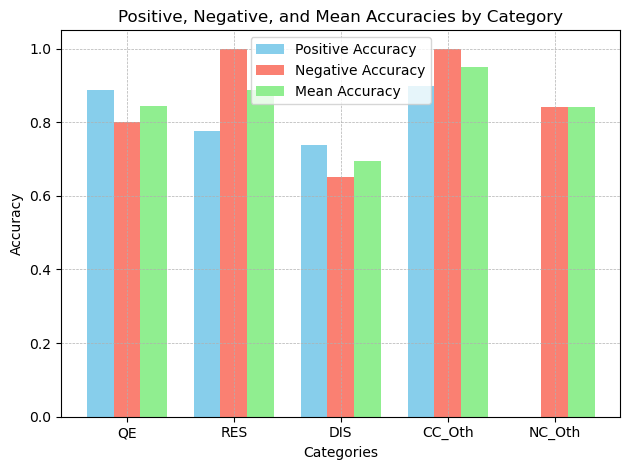

In [53]:
# Recategorising the interactions

# Check optimal threshold
print(optimal_threshold)

# We recall the split of the image data and split the associated interactions to match accordingly
train_interactions, valid_interactions, test_interactions = split_data(interaction,0.8,0.1)

# Looking at the test_interactions# Example array

# Get indices where value is either 0, 4, or 8 for CC_QE
CC_QE_ind = [index for index, value in enumerate(test_interactions) if value in [0, 4, 8]]
print("Indices where value is either 0, 4, or 8:", CC_QE_ind)

# Get indices where value is either 1, 5, or 9 for CC_RES
CC_RES_ind = [index for index, value in enumerate(test_interactions) if value in [1, 5, 9]]
print("Indices where value is either 1, 5, or 9:", CC_RES_ind)

# Get indices where value is either 2, 6, or 10 for CC_DIS
CC_DIS_ind = [index for index, value in enumerate(test_interactions) if value in [2, 6, 10]]
print("Indices where value is either 2, 6, or 10:", CC_DIS_ind)

# Get indices where value is either 3, 7, or 11 for CC_Oth
CC_Oth_ind = [index for index, value in enumerate(test_interactions) if value in [3, 7, 11]]
print("Indices where value is either 3, 7, or 11:", CC_Oth_ind)

# Get indices where value is either 12, 13, 14, 15 or 16 for NC_Oth
NC_Oth_ind = [index for index, value in enumerate(test_interactions) if value in [12, 13, 14, 15, 16]]
print("Indices where value is either 12, 13, 14, 15 or 16:", NC_Oth_ind)


# Split testing images according to the indices - and add channel dimension
test_QE = np.expand_dims(test_images[CC_QE_ind],axis=-1)
test_RES= np.expand_dims(test_images[CC_RES_ind],axis=-1)
test_DIS = np.expand_dims(test_images[CC_DIS_ind],axis=-1)
test_CC_Oth = np.expand_dims(test_images[CC_Oth_ind],axis=-1)
test_NC_Oth = np.expand_dims(test_images[NC_Oth_ind],axis=-1)

# Get the corresponding labels
label_QE = test_labels[CC_QE_ind]
label_RES = test_labels[CC_RES_ind]
label_DIS = test_labels[CC_DIS_ind]
label_CC_Oth = test_labels[CC_Oth_ind]
label_NC_Oth = test_labels[NC_Oth_ind]

# Split into two inputs and add channel dimension
QE_in_A, QE_in_B = test_QE[:,0,:,:,:], test_QE[:,1,:,:,:]
RES_in_A, RES_in_B = test_RES[:,0,:,:,:], test_RES[:,1,:,:,:]
DIS_in_A, DIS_in_B = test_DIS[:,0,:,:,:], test_DIS[:,1,:,:,:]
CC_Oth_in_A, CC_Oth_in_B = test_CC_Oth[:,0,:,:,:], test_CC_Oth[:,1,:,:,:]
NC_Oth_in_A, NC_Oth_in_B = test_NC_Oth[:,0,:,:,:], test_NC_Oth[:,1,:,:,:]

# Make Predictions
pred_QE = model.predict([QE_in_A,QE_in_B])
pred_RES = model.predict([RES_in_A,RES_in_B])
pred_DIS = model.predict([DIS_in_A,DIS_in_B])
pred_CC_Oth = model.predict([CC_Oth_in_A,CC_Oth_in_B])
pred_NC_Oth = model.predict([NC_Oth_in_A,NC_Oth_in_B])

# Define binary labels with optimal threshold
binary_labels_QE = (pred_QE > optimal_threshold).astype(int)
binary_labels_RES = (pred_RES > optimal_threshold).astype(int)
binary_labels_DIS = (pred_DIS > optimal_threshold).astype(int)
binary_labels_CC_Oth = (pred_CC_Oth > optimal_threshold).astype(int)
binary_labels_NC_Oth = (pred_NC_Oth > optimal_threshold).astype(int)

# Compute confusion matrix
tn0, fp0, fn0, tp0 = confusion_matrix(label_QE, binary_labels_QE).ravel()
tn1, fp1, fn1, tp1 = confusion_matrix(label_RES, binary_labels_RES).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(label_DIS, binary_labels_DIS).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(label_CC_Oth, binary_labels_CC_Oth).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(label_NC_Oth, binary_labels_NC_Oth).ravel()

# Calculate class accuracies
pos_accuracyQE = tp0/(tp0 + fn0)
neg_accuracyQE = tn0/(tn0 + fp0)
mean_accQE = (pos_accuracyQE + neg_accuracyQE)/2

pos_accuracyRES = tp1/(tp1 + fn1)
neg_accuracyRES = tn1/(tn1 + fp1)
mean_accRES = (pos_accuracyRES + neg_accuracyRES)/2

pos_accuracyDIS = tp2/(tp2 + fn2)
neg_accuracyDIS = tn2/(tn2 + fp2)
mean_accDIS = (pos_accuracyDIS + neg_accuracyDIS)/2

pos_accuracy_CCOth = tp3/(tp3 + fn3)
neg_accuracy_CCOth = tn3/(tn3 + fp3)
mean_accCCOth = (pos_accuracy_CCOth + neg_accuracy_CCOth)/2

# We have no positive results for NC/Other - hence we set the mean accuracy to the negative accuracy
neg_accuracy_NCOth = tn4/(tn4 + fp4)

# Check if the denominator is zero or NaN to avoid error
if tp4 + fn4 == 0:
    pos_accuracy_NCOth = np.nan
    mean_accNCOth = neg_accuracy_NCOth
else:
    pos_accuracy_NCOth = tp4 / (tp4 + fn4)
    mean_accNCOth = (pos_accuracy_NCOth + neg_accuracy_NCOth)/2


print('Mean Accuracies:',mean_accQE,mean_accRES,mean_accDIS,mean_accCCOth,mean_accNCOth)

# Plot the accuracies

# Define categories and corresponding accuracies
categories = ['QE', 'RES', 'DIS', 'CC_Oth', 'NC_Oth']
positive_accuracies = [pos_accuracyQE, pos_accuracyRES, pos_accuracyDIS, pos_accuracy_CCOth, pos_accuracy_NCOth]
negative_accuracies = [neg_accuracyQE, neg_accuracyRES, neg_accuracyDIS, neg_accuracy_CCOth, neg_accuracy_NCOth]
mean_accuracies = [mean_accQE, mean_accRES, mean_accDIS, mean_accCCOth, mean_accNCOth]

# Set colors for bars
color_positive = 'skyblue'
color_negative = 'salmon'
color_mean = 'lightgreen'

# Plotting bar chart for positive, negative, and mean accuracies
bar_width = 0.25
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, positive_accuracies, bar_width, color=color_positive, label='Positive Accuracy')
bar2 = ax.bar(index + bar_width, negative_accuracies, bar_width, color=color_negative, label='Negative Accuracy')
bar3 = ax.bar(index + 2*bar_width, mean_accuracies, bar_width, color=color_mean, label='Mean Accuracy')

ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Positive, Negative, and Mean Accuracies by Category')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories)
ax.legend()

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('Interaction_dep.png')
